In [1]:
import os
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv("https://osf.io/download/3qyut/")

In [3]:
raw_data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

In [5]:
# dropping columns with many missing variables (COGS, finished_prod, net_dom_sales, net_exp_sales, wages, D, exit_year, exit_data)

raw_data = raw_data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D', 'exit_year', 'exit_date'])

In [6]:
# adding age of firms

raw_data["age"] = np.where(
    raw_data["year"] - raw_data["founded_year"] < 0, 0, raw_data["year"] - raw_data["founded_year"])

In [7]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
raw_data = (
    raw_data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
raw_data = raw_data.replace("toReplace", np.nan)

In [8]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
raw_data["status_alive"] = (raw_data["sales"] > 0 & (False == raw_data["sales"].isna())).astype(int)

In [9]:
# defaults in 1 year if there are sales in this year but no sales one year later

raw_data["default"] = (
    (raw_data["status_alive"] == 1)
    & (raw_data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556944 entries, 0 to 556943
Data columns (total 43 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  556944 non-null  int64  
 1   comp_id               556944 non-null  float64
 2   begin                 287829 non-null  object 
 3   end                   287829 non-null  object 
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  fixed_assets          287698 non-null  float64
 11  inc_bef_tax           280392 non-null  float64
 12  intang_assets         287689 non-null  float64
 13  inventories           287698 non-null  float64
 14  liq_assets            287698 non-null  float64
 15  

In [11]:
# assets can't be negative. Change them to 0 and add a flag.
raw_data["flag_asset_problem"] = np.where(
    (
        (raw_data["intang_assets"] < 0)
        | (raw_data["curr_assets"] < 0)
        | (raw_data["fixed_assets"] < 0)
    ),
    1,
    0,
)
raw_data["flag_asset_problem"] = np.where(
    (
        (raw_data["intang_assets"].isna())
        | (raw_data["curr_assets"].isna())
        | (raw_data["fixed_assets"].isna())
    ),
    np.nan,
    raw_data["flag_asset_problem"],
)
raw_data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    287466
1.0       223
Name: comp_id, dtype: int64

In [12]:
# impute with 0 for asset problems

raw_data["intang_assets"] = np.where(raw_data["intang_assets"] < 0, 0, raw_data["intang_assets"])
raw_data["curr_assets"] = np.where(raw_data["curr_assets"] < 0, 0, raw_data["curr_assets"])
raw_data["fixed_assets"] = np.where(raw_data["fixed_assets"] < 0, 0, raw_data["fixed_assets"])

In [13]:
# generate total assets
raw_data["total_assets_bs"] = (
    raw_data["intang_assets"] + raw_data["curr_assets"] + raw_data["fixed_assets"]
)
round(raw_data["total_assets_bs"].describe(), 3)

count    2.876890e+05
mean     5.980575e+05
std      2.623770e+07
min      0.000000e+00
25%      4.792593e+03
50%      2.024815e+04
75%      8.810740e+04
max      1.032471e+10
Name: total_assets_bs, dtype: float64

In [14]:
# define P&L and Balance sheet column names

pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [15]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556944 entries, 0 to 556943
Data columns (total 45 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  556944 non-null  int64  
 1   comp_id               556944 non-null  float64
 2   begin                 287829 non-null  object 
 3   end                   287829 non-null  object 
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  fixed_assets          287698 non-null  float64
 11  inc_bef_tax           280392 non-null  float64
 12  intang_assets         287689 non-null  float64
 13  inventories           287698 non-null  float64
 14  liq_assets            287698 non-null  float64
 15  

In [38]:
# imputing labor_avg and dropping original column

raw_data["labor_avg_mod"] = np.where(
    raw_data["labor_avg"].isna(), raw_data["labor_avg"].mean(), raw_data["labor_avg"]
)
raw_data["flag_miss_labor_avg"] = (raw_data["labor_avg"].isna()).astype(int)
raw_data = raw_data.drop(['labor_avg'], axis=1)

In [39]:
holdout_data = raw_data[raw_data["ind2"] == 26]
holdout_data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,urban_m,region_m,founded_date,age,status_alive,default,flag_asset_problem,total_assets_bs,labor_avg_mod,flag_miss_labor_avg
156,2005,6.538183e+06,2005-01-01,2005-12-31,792.592590,6237.037109,348.148163,0.000000,0.000000,0.000000,...,2.0,East,1992-08-25,13.0,1,0,0.0,7940.740845,1.009435,1
162,2005,6.934257e+06,2005-05-13,2005-12-31,803.703674,4648.147949,9311.111328,0.000000,0.000000,0.000000,...,3.0,East,2005-04-26,NaN,1,1,0.0,16525.925293,1.009435,1
182,2005,8.416055e+06,2005-01-01,2005-12-31,3155.555664,71070.367188,25514.814453,74.074074,0.000000,-74.074074,...,1.0,Central,1995-08-28,10.0,1,0,0.0,83811.107712,1.009435,1
234,2005,1.242838e+07,2005-01-01,2005-12-31,3137.037109,1740.740723,2192.592529,0.000000,0.000000,0.000000,...,2.0,Central,1991-06-27,14.0,1,0,0.0,3666.666621,1.009435,1
261,2005,1.571155e+07,2005-01-01,2005-12-31,1592.592651,4740.740723,4970.370605,0.000000,7407.407227,7407.407227,...,1.0,Central,2001-09-01,4.0,1,0,0.0,5722.222229,1.009435,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556634,2016,4.580800e+11,2016-01-01,2016-12-31,3529.629639,125537.039062,0.000000,NaN,NaN,NaN,...,1.0,Central,1995-07-02,21.0,1,0,0.0,139803.706055,0.166667,0
556683,2016,4.591262e+11,2016-01-01,2016-12-31,4011.111084,58948.148438,30874.074219,NaN,NaN,NaN,...,3.0,East,1994-12-14,22.0,1,0,0.0,76837.037109,0.125000,0
556789,2016,4.610112e+11,2016-01-01,2016-12-31,148.148148,67448.148438,5059.259277,NaN,NaN,NaN,...,3.0,Central,1997-12-10,19.0,1,0,0.0,70522.222549,0.250000,0
556842,2016,4.620594e+11,2016-01-01,2016-12-31,559.259277,64011.109375,8662.962891,NaN,NaN,NaN,...,1.0,Central,1996-12-30,20.0,1,0,0.0,64011.109375,0.118056,0


In [40]:
# look at cross section
holdout_data = holdout_data.query("year==2014 & status_alive == 1")
# look at firms below 10m euro revenues and above 1000 euros
holdout_data = holdout_data.query("sales<=10000000 & sales>=1000")
holdout_data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,urban_m,region_m,founded_date,age,status_alive,default,flag_asset_problem,total_assets_bs,labor_avg_mod,flag_miss_labor_avg
417864,2014,6.538183e+06,2014-01-01,2014-12-31,1018.518494,17022.222656,3040.740723,0.0,0.0,0.0,...,2.0,East,1992-08-25,22.0,1,0,0.0,20381.481934,1.009435,1
417890,2014,8.416055e+06,2014-01-01,2014-12-31,425.925934,105740.742188,6918.518555,0.0,0.0,0.0,...,1.0,Central,1995-08-28,19.0,1,0,0.0,113359.260742,0.083333,0
417942,2014,1.242838e+07,2014-01-01,2014-12-31,0.000000,0.000000,9277.777344,0.0,0.0,0.0,...,2.0,Central,1991-06-27,23.0,1,0,0.0,0.000000,0.083333,0
417989,2014,1.777654e+07,2014-01-01,2014-12-31,48.148148,142296.296875,164237.031250,0.0,0.0,0.0,...,1.0,Central,1997-07-01,17.0,1,0,0.0,352633.328125,0.305556,0
417994,2014,1.862676e+07,2014-01-01,2014-12-31,5755.555664,95185.187500,45766.667969,0.0,0.0,0.0,...,2.0,West,2010-11-15,4.0,1,0,0.0,118003.705078,0.159091,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,0.000000,40740.742188,559.259277,0.0,0.0,0.0,...,2.0,East,1993-08-06,21.0,1,0,0.0,40740.742188,0.083333,0
463965,2014,4.610112e+11,2014-01-01,2014-12-31,429.629639,58781.480469,2651.851807,0.0,0.0,0.0,...,3.0,Central,1997-12-10,17.0,1,0,0.0,62318.517471,0.166667,0
464018,2014,4.620594e+11,2014-01-01,2014-12-31,1111.111084,68274.070312,16211.111328,0.0,0.0,0.0,...,1.0,Central,1996-12-30,18.0,1,0,0.0,69077.773987,0.250000,0
464032,2014,4.623300e+11,2014-01-01,2014-12-31,0.000000,17192.591797,7325.925781,0.0,0.0,0.0,...,2.0,East,2010-12-15,4.0,1,0,0.0,27537.036133,0.166667,0


In [41]:
round(holdout_data.sales.describe(), 3)

count       1037.000
mean      490202.218
std      1154087.414
min         1070.370
25%        21766.666
50%        72700.000
75%       333888.875
max      9576485.000
Name: sales, dtype: float64

In [42]:
holdout_data.default.value_counts()

default
0    981
1     56
Name: count, dtype: int64

The holdout_data now contains the right dataset (1037 observations, 56 defaults, correct sales figures).

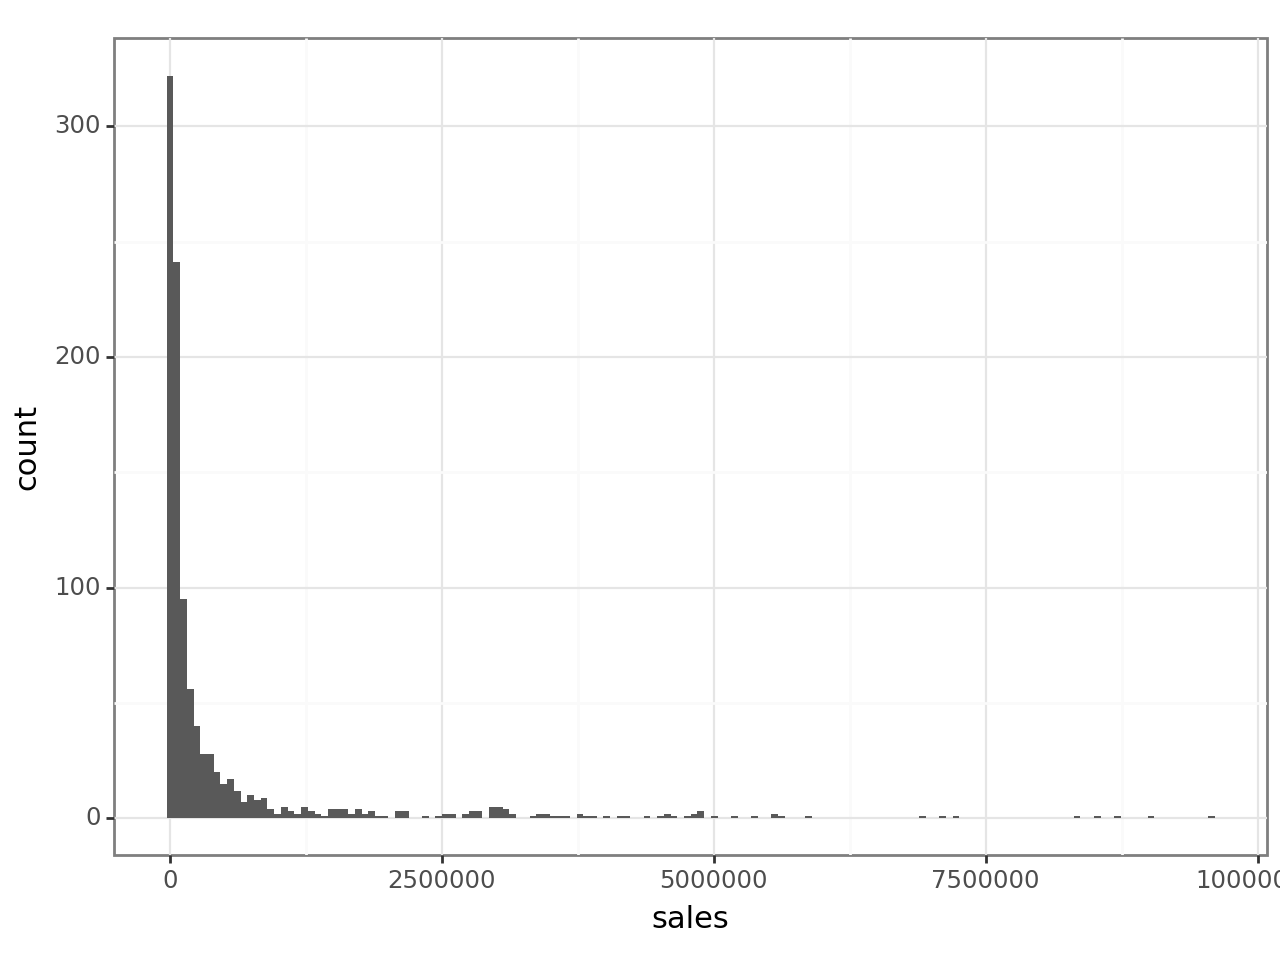

<Figure Size: (640 x 480)>

In [43]:
ggplot(holdout_data, aes("sales")) + geom_histogram() + theme_bw()

Most companies' sales are below 1M EUR in the holdout data.

# Feature engineering

For modeling, logistics regression and probability forest methods will be used. On top of the different methods, different training datasets will be used to create the most accurate model that performs the best as measured by the loss function on the holdout set.
The different training datasets will be taken from the `raw_data` DataFrame.


In [44]:
# data1 will be the same industry with the same sales figure restrictions, just one year before - this will be a relatively small dataset.

data1 = raw_data.query("year==2013 & status_alive == 1")
data1 = data1.query("sales<=10000000 & sales>=1000 & ind2 == 26")
data1.shape

(1050, 46)

In [45]:
data1.default.value_counts()

default
0    999
1     51
Name: count, dtype: int64

In [46]:
round(data1.sales.describe(), 3)

count       1050.000
mean      465587.543
std      1173668.081
min         1000.000
25%        21786.112
50%        70418.516
75%       283219.438
max      9811389.000
Name: sales, dtype: float64

This dataset has very similar number of defaults as our holdout dataset, although its mean sales are a bit lower. It is likely to be quite similar to it in other features too, althoug it is quite a small dataset (only 1050 observations).

In [47]:
# data2 will include all industries (except the target) with the same sales figure restrictions, from the same year as our holdout data.

data2 = raw_data.query("year==2014 & status_alive == 1")
data2 = data2.query("sales<=10000000 & sales>=1000 & ind2 != 26")
data2.shape

(20253, 46)

In [48]:
data2.default.value_counts()

default
0    18177
1     2076
Name: count, dtype: int64

The default rate is higher than in the holdout set (around 10% vs 5%) but it is a much bigger sample.

In [49]:
round(data2.sales.describe(), 3)

count      20253.000
mean      255986.021
std       806844.236
min         1000.000
25%        17407.408
50%        50481.480
75%       157407.406
max      9963926.000
Name: sales, dtype: float64

Average sales are significantly lower than in the holdout set (256k vs 490k).

In [50]:
# data3 will include the same industry but one year earlier and with an even narrower sales filter - 
# given that most of the companies in the holdout data have less than 1M EUR sales, this filter will be applied here.

data3 = raw_data.query("year==2013 & status_alive == 1")
data3 = data3.query("sales<=1000000 & sales>=1000 & ind2 == 26")
data3.shape

(936, 46)

In [51]:
# working capital = current assets / current liabilities

In [52]:
data1.info()
data2.info()
data3.info()
holdout_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 371452 to 417643
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  1050 non-null   int64  
 1   comp_id               1050 non-null   float64
 2   begin                 1050 non-null   object 
 3   end                   1050 non-null   object 
 4   amort                 1048 non-null   float64
 5   curr_assets           1050 non-null   float64
 6   curr_liab             1050 non-null   float64
 7   extra_exp             1050 non-null   float64
 8   extra_inc             1050 non-null   float64
 9   extra_profit_loss     1050 non-null   float64
 10  fixed_assets          1050 non-null   float64
 11  inc_bef_tax           1050 non-null   float64
 12  intang_assets         1050 non-null   float64
 13  inventories           1050 non-null   float64
 14  liq_assets            1050 non-null   float64
 15  material_exp       

The missing values are to be imputed with the average of the respective column. In some cases (E.g. birth_year, labor_avg) this will create quite a noisy data. For all imputations, flags are added.
Note: the imputations will be based on the averages of the respective datasets and not the averages of the total data.

In [53]:
to_filter=data1.isna().sum()
to_filter[to_filter>0]

amort              2
material_exp       2
personnel_exp      2
founded_year      92
ceo_count         92
foreign           92
female            92
birth_year       175
inoffice_days     92
gender            92
origin            92
region_m           2
age               92
dtype: int64

In [54]:
to_filter=data2.isna().sum()
to_filter[to_filter>0]

amort                   29
curr_assets             12
curr_liab               12
fixed_assets            12
intang_assets           12
inventories             12
liq_assets              12
material_exp            29
personnel_exp           29
profit_loss_year        12
share_eq                12
subscribed_cap          12
tang_assets             12
founded_year          1056
ceo_count             1055
foreign               1055
female                1055
birth_year            2707
inoffice_days         1055
gender                1055
origin                1055
nace_main                5
ind2                     5
ind                    637
region_m                58
founded_date             1
age                   1056
flag_asset_problem      12
total_assets_bs         12
dtype: int64

In [55]:
to_filter=data3.isna().sum()
to_filter[to_filter>0]

amort              1
material_exp       1
personnel_exp      1
founded_year      86
ceo_count         86
foreign           86
female            86
birth_year       136
inoffice_days     86
gender            86
origin            86
age               86
dtype: int64

In [56]:
# divide all bs_names elements by total_assets_bs and create new column for it
data1[[col + "_bs" for col in bs_names]] = (
    data1[bs_names]
    .div(data1["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data1[[col + "_bs"]] = np.where(
        data1["total_assets_bs"].isna(), np.nan, data1[col + "_bs"]
    )

ValueError: Columns must be same length as key

In [57]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 371452 to 417643
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  1050 non-null   int64  
 1   comp_id               1050 non-null   float64
 2   begin                 1050 non-null   object 
 3   end                   1050 non-null   object 
 4   amort                 1048 non-null   float64
 5   curr_assets           1050 non-null   float64
 6   curr_liab             1050 non-null   float64
 7   extra_exp             1050 non-null   float64
 8   extra_inc             1050 non-null   float64
 9   extra_profit_loss     1050 non-null   float64
 10  fixed_assets          1050 non-null   float64
 11  inc_bef_tax           1050 non-null   float64
 12  intang_assets         1050 non-null   float64
 13  inventories           1050 non-null   float64
 14  liq_assets            1050 non-null   float64
 15  material_exp       